<a href="https://colab.research.google.com/github/xjseabrum/comp_disc_S22_proj/blob/main/main_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [2]:
!python3 --version

Python 3.7.13


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os as os
os.chdir("/content/gdrive/MyDrive/comp_proj")

In [ ]:
!pip3 install -U sentence-transformers
!pip3 install -U numpy
!pip3 install kneed

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 12.7 MB/s 
     |████████████████████████████████| 1.2 MB 16.4 MB/s 
     |████████████████████████████████| 77 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=3723f16aa1ba52c8585296de01550b511bcec34ace0b57d05d9523f27ccb2e35
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 15.7 MB 119 kB/s 
  Attempting uninstall: numpy
    Found existing installation:

In [ ]:
# A Python interface to the Penn Discourse Treebank 2
!git clone https://github.com/cgpotts/pdtb2.git

fatal: destination path 'pdtb2' already exists and is not an empty directory.


In [ ]:
os.chdir("/content/gdrive/MyDrive/comp_proj/pdtb2")

In [ ]:
#import statements
from sklearn.cluster import KMeans
import numpy as np
from pdtb2 import CorpusReader, Datum
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from collections import Counter
import pandas as pd

# Data Extraction and Preprocessing

In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

model_sent = SentenceTransformer('all-mpnet-base-v2')
qa_search = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
semantic_serch = SentenceTransformer('sentence-transformers/msmarco-distilbert-dot-v5')# not good

def sent_transformer(sentences):
  embeddings = qa_search.encode(sentences)
  return embeddings


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
#Read in Data
X_sentences = []
y = []
rel_tag = []
iterator = CorpusReader('pdtb2.csv').iter_data(display_progress=False)
try:
    while(True):
        d = next(iterator)
        arg1 = d.Arg2_RawText
        arg2 = d.Arg2_Attribution_RawText
        relation = d.Relation
        connection = None
        if relation == "Explicit":
            connection = str(d.ConnHead).lower()
            X_sentences.append([str(d.Arg1_RawText).lower(),
                                str(d.ConnHead).lower(),
                                str(d.Arg2_RawText).lower()])
            y.append(str(d.ConnHead).lower())
            rel_tag.append(str(d.ConnHeadSemClass1).lower())
        '''
        if relation=="Implicit":
            connection=d.Conn1
            X_sentences.append([d.Arg1_RawText,connection,d.Arg2_RawText])
            y.append(connection)
        '''
except:
    print("end")

end


In [ ]:
# arg1 sentence and arg2 sentence
X_sentences[2]

['that hung over parts of the factory',
 'though',
 'exhaust fans ventilated the area']

In [ ]:
#connective phrase
y[2]

'though'

In [ ]:
len(X_sentences)

18459

In [ ]:
sent_transformer(X_sentences[0])

array([[-0.00721777, -0.01202236,  0.01896609, ..., -0.0222057 ,
         0.01569094,  0.06553906],
       [ 0.04021981,  0.04550669, -0.00812969, ...,  0.05893916,
         0.00597287, -0.03075969],
       [ 0.06705039,  0.05477949, -0.00219497, ...,  0.07351553,
         0.06312467,  0.0370192 ]], dtype=float32)

In [ ]:
def concate(arg1,conn,arg2):
    return np.concatenate(arg1,conn,arg2)
def similarity(arg1,conn,arg2):
    return np.concatenate([arg1, conn, arg2, np.absolute(np.subtract(arg1,arg2)), [np.dot(arg1,arg2)]])
def dot_product(arg1,conn,arg2):
    return np.concatenate([[np.dot(arg1,arg2)]])
n=len(X_sentences)

In [ ]:
# extract features use bert sentence transformers and concatenate two embedings.
# reference : https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# save features to file because it cost a lot of time extracting the features

n = len(X_sentences)
with open('features.npy', 'wb') as f:
  c = 1
  start = time.time()
  for sentences in X_sentences:
    feature = np.concatenate(model_sent.encode(sentences))
    np.save(f, feature)
    if c % 1000 == 0:
      print(str(c) + "/" + str(n) + " complete.")
    if c % n == 0:
      print(str(c) + "/" + str(n) + " complete.")
    c += 1
  end = time.time()
  print("Total runtime: {} seconds".format(round(end - start, 2)))

1000/18459 complete.
2000/18459 complete.
3000/18459 complete.
4000/18459 complete.
5000/18459 complete.
6000/18459 complete.
7000/18459 complete.
8000/18459 complete.
9000/18459 complete.
10000/18459 complete.
11000/18459 complete.
12000/18459 complete.
13000/18459 complete.
14000/18459 complete.
15000/18459 complete.
16000/18459 complete.
17000/18459 complete.
18000/18459 complete.
18459/18459 complete.
Total runtime: 219.72 seconds


In [ ]:
# load features from file

X = []
with open('features.npy', 'rb') as f:
  for _ in range(n):
    X.append(np.load(f,allow_pickle=True))

In [ ]:
len(X)

18459

In [ ]:
def view_labels(X, X_sentences, algo_labels, u, level="secondary"):
  # algo_labels is labels as found by the algorithm in 1D array form
  # u is number of clusters

  arg1s = [x[0] for x in X_sentences]
  arg2s = [x[2] for x in X_sentences]
  arg_conn = [x[1] for x in X_sentences]
  arg_label = [y for y in rel_tag]
  df = pd.DataFrame([arg1s,arg2s,arg_conn,algo_labels, arg_label]).transpose()
  df.columns = ['arg1','arg2','connective', 'algo', 'pdtb_tag']

  df[['primary', 'secondary', 'tertiary']] = df.pdtb_tag.str.split('.', expand=True)
  df['primary'] = df['primary'].fillna("<empty_1>")
  df['secondary'] = df['secondary'].fillna("<empty_2>")
  df['tertiary'] = df['tertiary'].fillna("<empty_3>")

  labels = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list1 = set(df2["connective"])
    [x, y] = [label, [tmp_list1]]
    labels.append([x,y])

  connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list2 = set(df2["algo"])
    [x,y] = [connective, [tmp_list2]]
    connective_to_label.append([x,y])

  pdtb_connective_to_label = []
  for word in range(len(list(set(df["connective"])))):
    connective = list(set(df["connective"]))[word] 
    df2 = df[df["connective"] == connective]
    tmp_list3 = set(df2[level])
    [x,y] = [connective, [tmp_list3]]
    pdtb_connective_to_label.append([x,y])

  pdtb_label_connectives = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list4 = set(df2["connective"])
    [x, y] = [label_word, [tmp_list4]]
    pdtb_label_connectives.append([x,y])

  algo_to_pdtb = []
  for label in range(u):
    df2 = df[df['algo'] == label]
    tmp_list5 = set(df2[level])
    [x, y] = [label, [tmp_list5]]
    algo_to_pdtb.append([x,y])

  pdtb_to_algo = []
  for label in range(len(list(set(df[level])))):
    label_word = list(set(df[level]))[label]
    df2 = df[df[level] == label_word]
    tmp_list6 = set(df2["algo"])
    [x, y] = [label_word, [tmp_list6]]
    pdtb_to_algo.append([x,y])

  return df, labels, connective_to_label, pdtb_connective_to_label, pdtb_label_connectives, algo_to_pdtb, pdtb_to_algo

# KMEANS

## Kmeans- range

In [ ]:

distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    print(k)


OSError: ignored

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


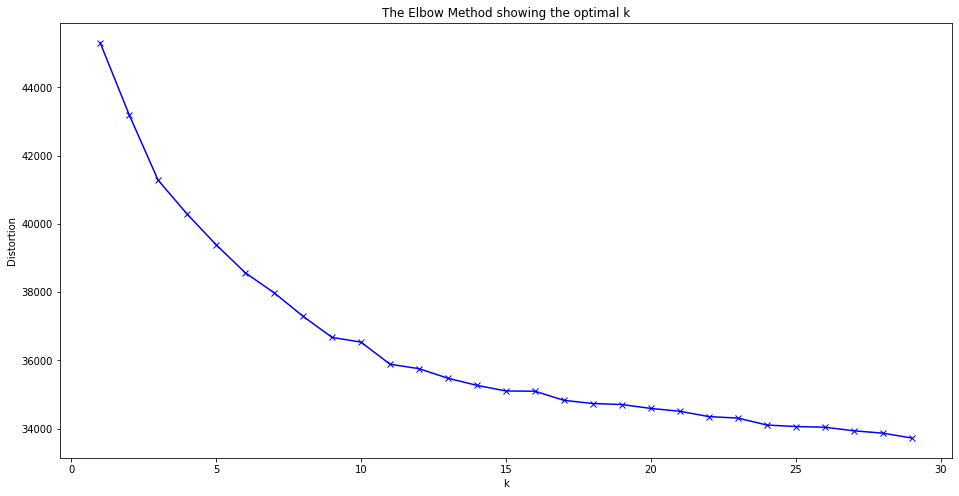

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

9


<Figure size 360x360 with 0 Axes>

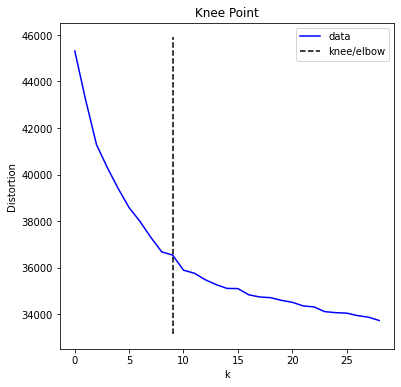

In [ ]:
#use knee locater to locate elbow point
from kneed import KneeLocator
i = np.arange(len(distortions))
knee = KneeLocator(i, distortions, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("k")
plt.ylabel("Distortion")

print(knee.knee)


In [ ]:
#Notes from Jay
#run kmeans instead on the full sentence so that the connective is 
#appropriately contextualized

# Then either concatenate the connective's embedding on its own
# to the end of the sentence
# or some other transformation dot(full_sentence, connective)
# and pass that through into k-means
# also dont forget to put the entire sentence as lowercase
# or uppercase if you feel angry.

## KMeans - individual

In [ ]:
# unique connectives 
u = knee.knee

In [ ]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters = u, 
                random_state=0).fit(X)

In [ ]:
# (connective, predicted label),frequency
#counter=Counter(zip(y,kmeans.labels_))
#counter.most_common(10)

In [ ]:
df, labels_K, connective_to_label_K, pdtb_conn_labels, pdtb_labels, algo_pdtb, pdtb_algo = view_labels(X, X_sentences, kmeans.labels_, u)

In [ ]:
labels_K

[[0, [{'as', 'as if', 'as though', 'for example', 'for instance', 'much as'}]],
 [1, [{'as if', 'if', 'if then'}]],
 [2,
  [{'additionally',
    'also',
    'as well',
    'furthermore',
    'in addition',
    'moreover',
    'plus'}]],
 [3, [{'and'}]],
 [4,
  [{'after',
    'afterward',
    'before',
    'before and after',
    'earlier',
    'previously',
    'thereafter'}]],
 [5,
  [{'as soon as', 'by then', 'if and when', 'since', 'when', 'when and if'}]],
 [6,
  [{'accordingly',
    'alternatively',
    'although',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as though',
    'besides',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'further',
    'hence',
    'however',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'indeed',
    'ins

In [ ]:
connective_to_label_K

[['once', [{6}]],
 ['specifically', [{6}]],
 ['thus', [{6}]],
 ['in the end', [{6}]],
 ['as', [{0}]],
 ['consequently', [{6}]],
 ['conversely', [{6}]],
 ['in addition', [{2}]],
 ['if and when', [{5}]],
 ['and', [{3}]],
 ['separately', [{6}]],
 ['whereas', [{6}]],
 ['ultimately', [{6}]],
 ['in particular', [{6}]],
 ['also', [{2}]],
 ['before and after', [{4}]],
 ['because', [{7}]],
 ['if', [{1}]],
 ['further', [{6}]],
 ['as though', [{0, 6}]],
 ['yet', [{6}]],
 ['as long as', [{6}]],
 ['lest', [{6}]],
 ['besides', [{6}]],
 ['nonetheless', [{6}]],
 ['thereby', [{6}]],
 ['nor', [{6}]],
 ['regardless', [{6}]],
 ['since', [{5}]],
 ['by comparison', [{6}]],
 ['moreover', [{2}]],
 ['while', [{6}]],
 ['so', [{6}]],
 ['except', [{6}]],
 ['therefore', [{6}]],
 ['in fact', [{6}]],
 ['before', [{4}]],
 ['either or', [{6}]],
 ['on the contrary', [{6}]],
 ['on the other hand', [{6}]],
 ['finally', [{6}]],
 ['when and if', [{5}]],
 ['otherwise', [{6}]],
 ['insofar as', [{6}]],
 ['afterward', [{4}]],


In [ ]:
cols = [i for i in range(u)]
conntive_clusters = [list(x[1][0]) for x in labels_K]
df = pd.DataFrame(conntive_clusters).transpose()
df.columns = cols
df

,0,1,2,3,4,5,6,7,8
0,much as,if then,furthermore,and,before,if and when,besides,because,though
1,for example,if,additionally,None,afterward,since,otherwise,None,but
2,for instance,as if,as well,None,earlier,as soon as,insofar as,None,None
3,as if,None,also,None,thereafter,when,nonetheless,None,None
4,as though,None,moreover,None,after,by then,although,None,None
...,...,...,...,...,...,...,...,...,...
66,None,None,None,None,None,None,meanwhile,None,None
67,None,None,None,None,None,None,accordingly,None,None
68,None,None,None,None,None,None,indeed,None,None
69,None,None,None,None,None,None,similarly,None,None


In [ ]:
from pathlib import Path  
filepath = Path('out_dotproduct_5_semanticSearchEmbedding.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)  

In [ ]:
def tag_visualization(kmeans_label,pdtb_tag):
  col=["kmeans_label","pdtb_tag"]
  df = pd.DataFrame([kmeans_label,pdtb_tag]).transpose()
  df.columns = cols
  df


## t-SNE Visualization using KMeans Clusters

https://builtin.com/data-science/unsupervised-learning-python
"One of the unsupervised learning methods for visualization is t-distributed stochastic neighbor embedding, or t-SNE. It maps high-dimensional space into a two or three-dimensional space which can then be visualized. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability"

In [ ]:
# Defining Model
model = TSNE(learning_rate=100)
# Fitting Model
transformed = model.fit_transform(X)
num_clusters = 11

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

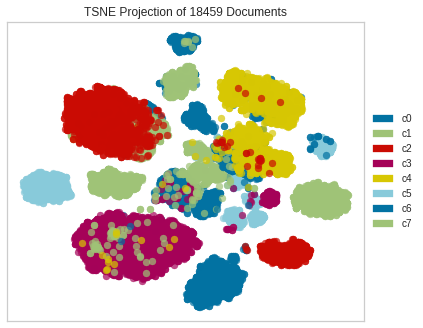

In [ ]:
from yellowbrick.text import TSNEVisualizer
clusters = KMeans(n_clusters=num_clustesrs)
clusters.fit(transformed)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()

In [ ]:
labels_tSNE,connective_to_label_tSNE = view_labels(X, X_sentences, clusters.labels_, num_clusters)

NameError: ignored

In [ ]:
labels_tSNE

[[0,
  [{'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as an alternative',
    'as well',
    'before',
    'besides',
    'but',
    'by then',
    'else',
    'finally',
    'for',
    'however',
    'if',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'insofar as',
    'later',
    'likewise',
    'moreover',
    'on the contrary',
    'regardless',
    'separately',
    'specifically',
    'then',
    'though',
    'ultimately',
    'whereas'}]],
 [1,
  [{'and',
    'but',
    'by comparison',
    'by contrast',
    'however',
    'in contrast',
    'meantime',
    'meanwhile',
    'nevertheless',
    'nonetheless',
    'on the one hand on the other hand',
    'on the other hand',
    'still',
    'though',
    'whereas',
    'while',
    'yet'}]],
 [2,
  [{'also',
    'and',
    'as',
    'as though',
    'conversely',
    'indeed',
    'much as',
    'overall'}]],
 [3,
  

In [ ]:
connective_to_label_tSNE

# DBSCAN

Following: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

the linear boundary of the k-means clustering definitely does not work well. However, DBSCAN doesn’t require any shape of the clusters but tracks the high-density regions

There are a few implicit assumptions in this approach:
*   Densities across all the clusters are the same.
*   Cluster sizes or standard deviations are the same.


A large eps tend to include more points within a cluster, so a too-large eps will include everything in the same single cluster and a too-small eps will result in no clustering at all.

A too-small minPts is not meaningful because it will regard every point as a core point. A relatively larger minPts can be better to deal with data with more noises.

## Finding Parameters using nearest neighbors

In [ ]:
#use nearest neighbors to help calculate our eps argument with dbscan

In [ ]:
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/stable/modules/neighbors.html
#start by using sqrt(N) for number of neighbors

#two different approaches
#num_neighs = round(len(X)/11) #naively we expect around 11 clusters 
num_neighs = 100

nearest_neighbors = NearestNeighbors(n_neighbors=num_neighs)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

Text(0, 0.5, 'Distance')

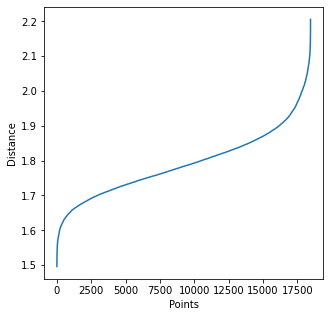

In [ ]:
#plot
distances_sorted = np.sort(distances[:,100-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")

#When num_neighs = len(X)/11 -- could look at other elbow point in data

1.8964247


<Figure size 360x360 with 0 Axes>

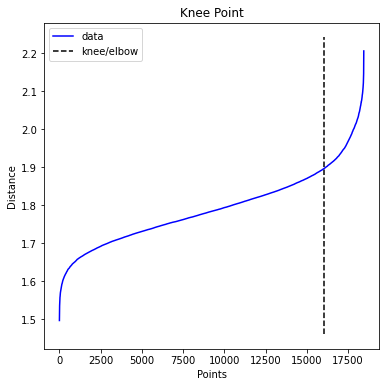

In [ ]:
#find eps from the above graph using KneeLocator to Detect Elbow Point
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances_sorted, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(knee.knee_y)

## Run Model

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=1.65, min_samples=25).fit(X)
#print(DBSCAN_cluster.labels_)

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("Num_clusters: " + str(num_clusters))
print("Percentage of points that are outliers: " + str(percentage_outliers))

Num_outliers: 7348
Num_clusters: 3
Percentage of points that are outliers: 39.80714014843708


In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
df,labels_DBSCAN,connective_to_label_DBSCAN, _, _, _, _ = view_labels(X, X_sentences, DBSCAN_labels, len(set(DBSCAN_labels)))

In [ ]:
# label 0 is outlier data if num_outliers > 0
labels_DBSCAN

[[0,
  [{'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'before and after',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'indeed',
    'insofar as',
    'instead',
    'later',
    'lest',
    'likewise',
    'meantime',
    'meanwhile',
    'moreover',
    'much as',
    'neither nor',


In [ ]:
u = len(labels_DBSCAN)
cols = [i for i in range(u)]
conntive_clusters = [list(x[1][0]) for x in labels_DBSCAN]
df = pd.DataFrame(conntive_clusters).transpose()
df.columns = cols
df

,0,1,2,3
0,once,furthermore,for example,instead
1,specifically,otherwise,for instance,None
2,thus,nonetheless,None,None
3,in the end,although,None,None
4,as,for example,None,None
...,...,...,...,...
95,likewise,None,None,None
96,meantime,None,None,None
97,accordingly,None,None,None
98,after,None,None,None


In [ ]:
from pathlib import Path  
filepath = Path('DBSCAN_semanticEmbed_similarityConcate-16.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)  

In [ ]:
labels_DBSCAN

[[0,
  [{'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'before and after',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'indeed',
    'insofar as',
    'instead',
    'later',
    'lest',
    'likewise',
    'meantime',
    'meanwhile',
    'moreover',
    'much as',
    'neither nor',


##DBSCAN - TSNE

In [ ]:
#Def model:
model = TSNE(learning_rate = 100)

# Fitting model 
transformed = model.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


### finding parameters with visualization

eps:1.5, num_clusters:59
eps:1.6, num_clusters:54
eps:1.7000000000000002, num_clusters:52
eps:1.8000000000000003, num_clusters:50
eps:1.9000000000000004, num_clusters:48
eps:2.0000000000000004, num_clusters:47
eps:2.1000000000000005, num_clusters:46
eps:2.2000000000000006, num_clusters:46
eps:2.3000000000000007, num_clusters:43
eps:2.400000000000001, num_clusters:41


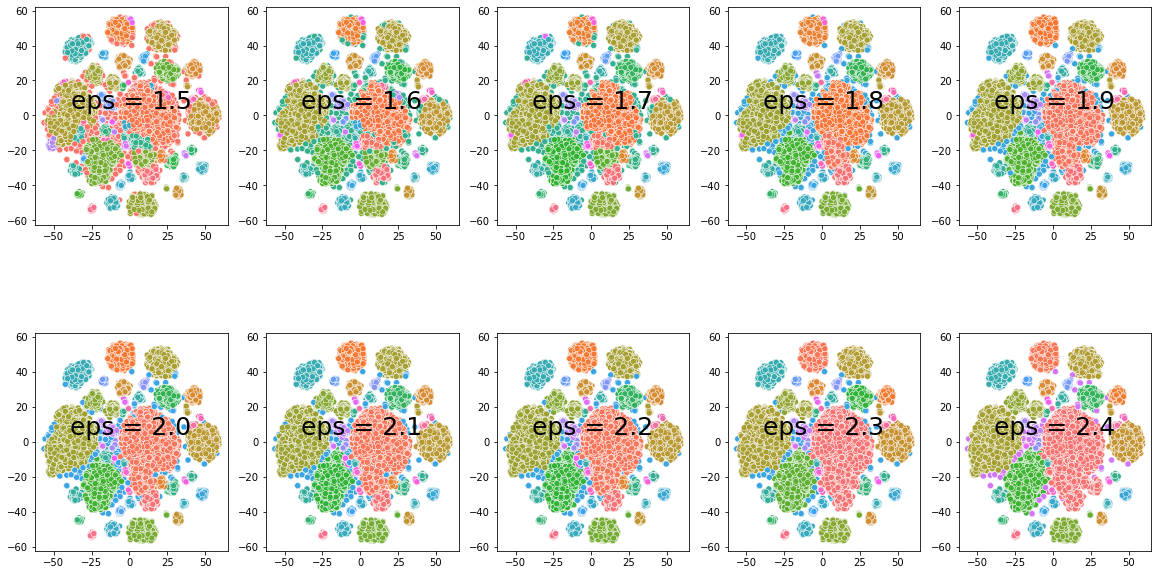

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
ran = np.arange(1.5, 2.5, 0.1)
for x in ran:
  eps = x
  db = DBSCAN(eps=eps, min_samples=20).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("eps:" + str(eps) + ", num_clusters:" + str(len(np.unique(labels))))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

In [ ]:
#finding the optimal min_samples using visualization
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
eps = 1.8
ran = np.arange(5,55,5)
for x in ran:
  min_s = x
  db = DBSCAN(eps=eps, min_samples=min_s).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("min_samples:" + str(min_s) + ", num_clusters:" + str(len(np.unique(labels))) + ", percent_outliers: " + str((np.sum(labels == -1))/len(DBSCAN_cluster.labels_) * 100))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "m_s = {}".format(round(min_s, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

NameError: ignored

<Figure size 1440x720 with 0 Axes>

### run model using the parameters found

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=1.82, min_samples=20).fit(transformed)
#print(DBSCAN_cluster.labels_)

NameError: ignored

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("num clusters: " + str(num_clusters))
print("percentage of points that are outliers: " + str(percentage_outliers))

In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
df, labels_DBSCAN,connective_to_label_DBSCAN,_,_,_,_ = view_labels(X, X_sentences, DBSCAN_labels, len(set(DBSCAN_labels)))

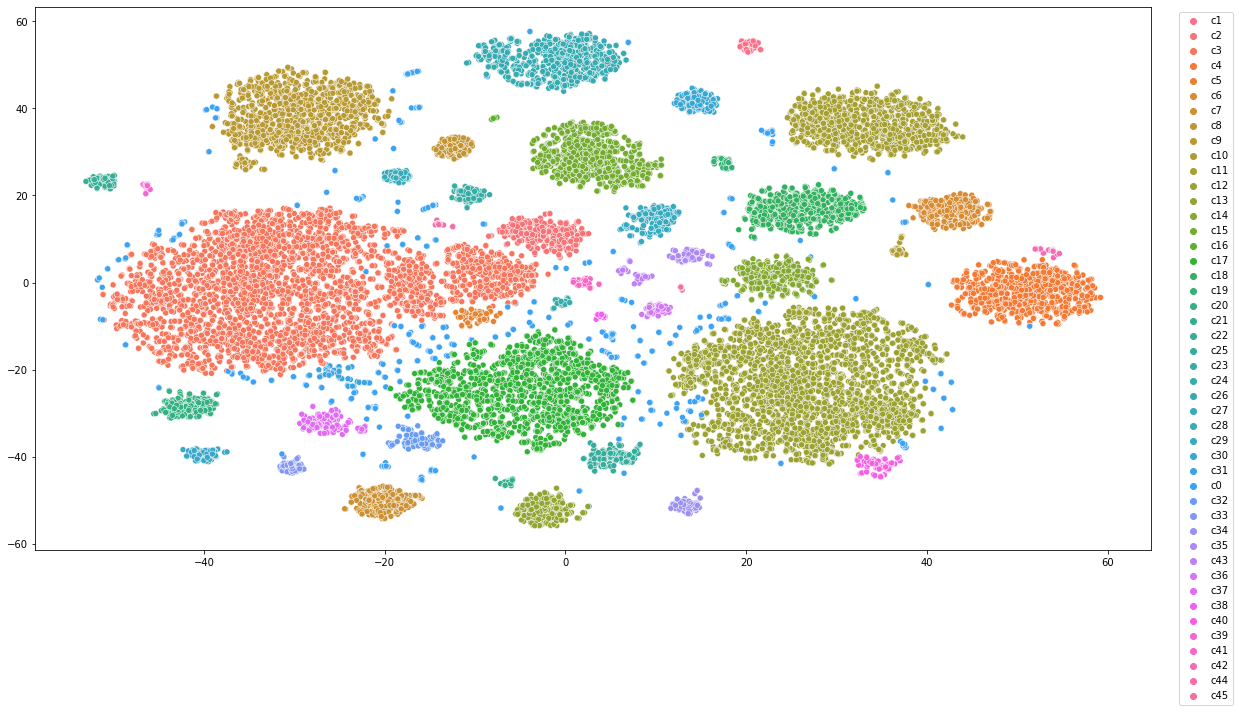

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["c{}".format(x) for x in DBSCAN_labels])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
labels_DBSCAN

,arg1,arg2,connective,algo,pdtb_tag,primary,secondary,tertiary
0,"the asbestos fiber, crocidolite, is unusually ...",it enters the lungs,once,1,temporal.asynchronous.succession,temporal,asynchronous,succession
1,the latest results appear in today's new engla...,preliminary findings were reported more than a...,although,2,comparison.contrast,comparison,contrast,<empty_3>
2,that hung over parts of the factory,exhaust fans ventilated the area,though,3,comparison.concession.expectation,comparison,concession,expectation
3,there's no question that some of those workers...,you have to recognize that these events took p...,but,3,comparison.contrast,comparison,contrast,<empty_3>
4,longer maturities are thought to indicate decl...,they permit portfolio managers to retain relat...,because,4,contingency.cause.reason,contingency,cause,reason
...,...,...,...,...,...,...,...,...
18454,the government is watching closely to see if t...,the government is figuring that the releases c...,in addition,25,expansion.conjunction,expansion,conjunction,<empty_3>
18455,that the releases could create a split between...,the men will be faced with bridging the genera...,also,16,expansion.conjunction,expansion,conjunction,<empty_3>
18456,we emphasize discipline,"we know that the government is very, very sens...",because,4,contingency.cause.reason,contingency,cause,reason
18457,we want to see nelson mandela and all our comr...,if we aren't disciplined we may not see them h...,and,12,expansion.conjunction,expansion,conjunction,<empty_3>


# Extra Models

## Affinity Propogation

https://scikit-learn.org/stable/modules/clustering.html
"AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given."

Not enough RAM to do this

In [ ]:
from sklearn.cluster import AffinityPropagation
# Fit Affinity Propagation with Scikit
afprop = AffinityPropagation(max_iter=250)
afprop.fit(X)
cluster_centers_indices = afprop.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
# Predict the cluster for all the samples
P = afprop.predict(X)


## Mean-Shift

https://scikit-learn.org/stable/modules/clustering.html

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [ ]:
from sklearn.cluster import MeanShift
ms = MeanShift(max_iter = 10)
ms.fit(X)


KeyboardInterrupt: ignored

In [ ]:
num_clusters = len(set(ms.labels))
labels_MS,connective_to_label_MS = view_labels(X, X_sentences, ms.labels, num_clusters)



## Hierarchal Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 4).fit(X)
clustering.labels_